## Imports

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

## Dataset preparation

In [3]:
TRAINING_DATA_DIR = "data/training_data"

data_files = [f"{TRAINING_DATA_DIR}/{file}" for file in os.listdir(TRAINING_DATA_DIR)]
dataset = tf.data.TFRecordDataset(filenames=data_files,
                                  compression_type="GZIP",
                                  num_parallel_reads=4)

In [4]:
possible_results = ["0-1", "1-0", "1/2-1/2"]
result_to_onehot = tf.keras.layers.StringLookup(
    vocabulary=possible_results,
    # Ideally, this would be 0 but it returns a numpy error when 0.
    # Instead, we will just remove the first dimension after applying
    # this
    num_oov_indices=1,
    output_mode="one_hot")

for result in possible_results:
    print(f"{result} -> {result_to_onehot(result)[1:]}")

0-1 -> [1. 0. 0.]
1-0 -> [0. 1. 0.]
1/2-1/2 -> [0. 0. 1.]


In [5]:
MAX_SEQUENCE_LENGTH = 1024

pieces = ["p", "n", "b", "r", "q", "k"]
rank_names = ["1", "2", "3", "4", "5", "6", "7", "8"]
file_names = ["a", "b", "c", "d", "e", "f", "g", "h"]
squares = [f + r for r in rank_names for f in file_names]
promotions = ["-", "=n", "=b", "=r", "=q"]
possible_tokens = pieces + squares + promotions

moves_vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int",
    vocabulary=possible_tokens,
    standardize=None,
    split="whitespace",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

print("Example conversion")
sample_game = "p e2 e4 - p a7 a5 - b f1 c4 - p c7 c5 - q d1 f3 - p e7 e5 - q f3 f7 -"
print("Original:", sample_game)
print("Vectorized:", moves_vectorizer(sample_game).numpy()[:40])
print()

for token in possible_tokens:
    print(f"{token} -> {moves_vectorizer(token)[0]}")

Example conversion
Original: p e2 e4 - p a7 a5 - b f1 c4 - p c7 c5 - q d1 f3 - p e7 e5 - q f3 f7 -
Vectorized: [ 2 20 36 72  2 56 40 72  4 13 34 72  2 58 42 72  6 11 29 72  2 60 44 72
  6 29 61 72  0  0  0  0  0  0  0  0  0  0  0  0]

p -> 2
n -> 3
b -> 4
r -> 5
q -> 6
k -> 7
a1 -> 8
b1 -> 9
c1 -> 10
d1 -> 11
e1 -> 12
f1 -> 13
g1 -> 14
h1 -> 15
a2 -> 16
b2 -> 17
c2 -> 18
d2 -> 19
e2 -> 20
f2 -> 21
g2 -> 22
h2 -> 23
a3 -> 24
b3 -> 25
c3 -> 26
d3 -> 27
e3 -> 28
f3 -> 29
g3 -> 30
h3 -> 31
a4 -> 32
b4 -> 33
c4 -> 34
d4 -> 35
e4 -> 36
f4 -> 37
g4 -> 38
h4 -> 39
a5 -> 40
b5 -> 41
c5 -> 42
d5 -> 43
e5 -> 44
f5 -> 45
g5 -> 46
h5 -> 47
a6 -> 48
b6 -> 49
c6 -> 50
d6 -> 51
e6 -> 52
f6 -> 53
g6 -> 54
h6 -> 55
a7 -> 56
b7 -> 57
c7 -> 58
d7 -> 59
e7 -> 60
f7 -> 61
g7 -> 62
h7 -> 63
a8 -> 64
b8 -> 65
c8 -> 66
d8 -> 67
e8 -> 68
f8 -> 69
g8 -> 70
h8 -> 71
- -> 72
=n -> 73
=b -> 74
=r -> 75
=q -> 76


In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

feature_description = {
    "moves": tf.io.FixedLenFeature([], tf.string, default_value=''),
    "white_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "black_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "result": tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def prepare_example(example_proto):
    example = tf.io.parse_example(example_proto, feature_description)
    # [:,1:] is used to remove out-of-vocabulary index
    result_embedding = result_to_onehot(example["result"])[:,1:]
    tokenized_moves = moves_vectorizer(example["moves"])
    return tokenized_moves, example["white_elo"], example["black_elo"], result_embedding

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_example, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

ds = make_batches(dataset)

## InputEmbedding Layer

In [7]:
class InputEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim)

    def call(self, x):
        x = self.embedding_layer(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        return x

In [8]:
vocab_size = moves_vectorizer.vocabulary_size()
test_input_embedding = InputEmbedding(vocab_size=vocab_size, embedding_dim=5)
for moves, white_elo, black_elo, result in ds.take(1):
    print(test_input_embedding(moves).shape)

(64, 1024, 5)


## PositionalEmbedding Layer

In [9]:
def positional_encoding(length, depth):
    half_depth = depth / 2
    
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(half_depth)[np.newaxis, :] / half_depth
    
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)
    
    return tf.cast(pos_encoding[:,:depth], dtype=tf.float32)

In [10]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super().__init__()
        self.positional_embedding = positional_encoding(
            length=2048, depth=embedding_dim)
        
    def call(self, x):
        sequence_length = tf.shape(x)[1]
        x += self.positional_embedding[tf.newaxis, :sequence_length, :]
        return x

In [11]:
length = 10
dim = 5
positional_embedding_test = PositionalEmbedding(dim)
x = np.zeros((65, length, dim))
positional_embedding_test(x).shape

TensorShape([65, 10, 5])

## MultiHeadAttention Layer

In [12]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)
 
    def call(self, queries, keys, values, training):
        d_k = tf.cast(values.shape[-1], tf.float32)
        
        scores = tf.linalg.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(d_k)
 
        weights = tf.nn.softmax(scores)

        weights = self.dropout_layer(weights, training)

        return tf.linalg.matmul(weights, values)

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k, d_v, d_out, dropout_rate):
        super().__init__()
        self.num_heads = num_heads
        self.attention_layer = DotProductAttention(dropout_rate)
        # The dimension is d_k * num_heads so we can
        # perform all computations in parallel
        self.W_q = tf.keras.layers.Dense(d_k * num_heads)
        self.W_k = tf.keras.layers.Dense(d_k * num_heads)
        self.W_v = tf.keras.layers.Dense(d_v * num_heads)
        self.W_o = tf.keras.layers.Dense(d_out)

    def reshape_qkv(self, x, reverse=False):
        if not reverse:
            # x.shape == (num_batches, sequence_length, d * num_heads)
            # where d in {d_k, d_v}
            num_batches, sequence_length, _ = tf.shape(x)
            x = tf.reshape(x, shape=(num_batches, sequence_length, self.num_heads, -1))
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            # Now x.shape == (num_batches, num_heads, sequence_length, d)
        else:
            num_batches, num_heads, sequence_length, d = tf.shape(x)
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            x = tf.reshape(x, shape=(num_batches, sequence_length, d * num_heads))
        return x
        
    def call(self, queries, keys, values, training=None):
        q_reshaped = self.reshape_qkv(self.W_q(queries))
        k_reshaped = self.reshape_qkv(self.W_k(keys))
        v_reshaped = self.reshape_qkv(self.W_v(values))

        output_reshaped = self.attention_layer(q_reshaped, k_reshaped, v_reshaped, training)
        output = self.reshape_qkv(output_reshaped, reverse=True)

        return self.W_o(output)

In [14]:
input_seq_length = 5  # Maximum length of the input sequence
num_heads = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 128  # Dimensionality of the linearly projected values
d_out = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1 # The dropout propability for the attention weights
 
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))

multihead_attention_test = MultiHeadAttention(num_heads, d_k, d_v, d_out, dropout_rate)

multihead_attention_test(queries, keys, values).shape

TensorShape([64, 5, 512])

## GlobalSelfAttention Layer

In [15]:
class GlobalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k, dropout_rate=0.1):
        super().__init__()
        self.multihead_attention_layer = MultiHeadAttention(num_heads, d_k, d_k, d_k, dropout_rate)
        self.add_layer = tf.keras.layers.Add()
        self.normalization_layer = tf.keras.layers.LayerNormalization()

    def call(self, x):
        attention_output = self.multihead_attention_layer(
            queries=x, keys=x, values=x)
        x = self.add_layer([x, attention_output])
        x = self.normalization_layer(x)
        return x

In [16]:
input_seq_length = 5  # Maximum length of the input sequence
num_heads = 8  # Number of self-attention heads
d_k = 512  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1 # The dropout propability for the attention weights
 
x = np.random.random((batch_size, input_seq_length, d_k))

self_attention_test = GlobalSelfAttention(num_heads, d_k, dropout_rate)
self_attention_test(x).shape

TensorShape([64, 5, 512])

## FeedForward Layer

In [17]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_k, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_k),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add_layer = tf.keras.layers.Add()
        self.normalization_layer = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = self.add_layer([x, self.seq(x)])
        x = self.normalization_layer(x) 
        return x

In [18]:
input_seq_length = 5  # Maximum length of the input sequence
num_heads = 8  # Number of self-attention heads
d_k = 512  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1 # The dropout propability for the attention weights
 
x = np.random.random((batch_size, input_seq_length, d_k))

self_attention_test = GlobalSelfAttention(num_heads, d_k, dropout_rate)
feedforward_test = FeedForward(d_k, 2048)
feedforward_test(self_attention_test(x)).shape

TensorShape([64, 5, 512])

## EncoderLayer Layer

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention_layer = GlobalSelfAttention(num_heads, d_k, dropout_rate)
        self.ffn = FeedForward(d_k, dff)

    def call(self, x):
        x = self.self_attention_layer(x)
        x = self.ffn(x)
        return x

In [20]:
input_seq_length = 5  # Maximum length of the input sequence
num_heads = 8  # Number of self-attention heads
d_k = 512  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1 # The dropout propability for the attention weights
 
x = np.random.random((batch_size, input_seq_length, d_k))

encoder_layer_test = EncoderLayer(num_heads, d_k, 2048, dropout_rate)
encoder_layer_test(x).shape

TensorShape([64, 5, 512])

## Encoder

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, vocab_size, d_k, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.input_embedding_layer = InputEmbedding(vocab_size, d_k)
        self.positional_embedding_layer = PositionalEmbedding(d_k)
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        self.encoder_layers = tf.keras.Sequential([
            EncoderLayer(num_heads, d_k, dff, dropout_rate)
            for _ in range(num_layers)
        ])

    def call(self, x):
        x = self.input_embedding_layer(x)
        x = self.positional_embedding_layer(x)
        x = self.dropout_layer(x)
        x = self.encoder_layers(x)
        return x

In [22]:
input_seq_length = 5  # Maximum length of the input sequence
num_layers = 3 # Number of encoder layers
num_heads = 8  # Number of self-attention heads
d_k = 512  # Dimensionality of the linearly projected queries and keys
dff = 2048
dropout_rate = 0.1 # The dropout propability for the attention weights
vocab_size = moves_vectorizer.vocabulary_size()

encoder_test = Encoder(num_layers, vocab_size, d_k, num_heads, dff, dropout_rate)
for moves, white_elo, black_elo, result in ds.take(2):
    print(encoder_test(moves, training=True).shape)

(64, 1024, 512)
(64, 1024, 512)


## EloRegression Layer

In [38]:
class EloRegression(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
        ])
        # We will output two elo scores
        self.output_layer = tf.keras.layers.Dense(2, activation="relu")

    def call(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [39]:
d_k = 512  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process

x = np.random.random((batch_size, d_k))
elo_regression_test = EloRegression()
elo_regression_test(x).shape

TensorShape([64, 2])

## ResultClassification Layer

In [40]:
class ResultClassification(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
        ])
        # There are three possible results
        self.output_layer = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [41]:
d_k = 512  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process

x = np.random.random((batch_size, d_k))
result_classification_test = ResultClassification()
result_classification_test(x).shape

TensorShape([64, 3])

## Chessformer Model

In [42]:
class Chessformer(tf.keras.Model):
    def __init__(self, num_layers, vocab_size, d_k, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, vocab_size, d_k, num_heads, dff, dropout_rate)
        self.elo_regression_head = EloRegression()
        self.result_classification_head = ResultClassification()

    def call(self, moves):
        moves = self.encoder(moves)
        # moves.shape == (batch_num, sentence_length, d_k)
        game_embedding = tf.reduce_mean(moves, axis=1) # Average the embeddings for all tokens
        elos = self.elo_regression_head(game_embedding)
        result = self.result_classification_head(game_embedding)
        return elos, result

In [43]:
num_layers = 3 # Number of encoder layers
num_heads = 8  # Number of self-attention heads
d_k = 512  # Dimensionality of the linearly projected queries and keys
dff = 2048
dropout_rate = 0.1 # The dropout propability for the attention weights
vocab_size = moves_vectorizer.vocabulary_size()

chessformer_test = Chessformer(num_layers, vocab_size, d_k, num_heads, dff, dropout_rate)
for moves, white_elo, black_elo, result in ds.take(1):
    elos, result = chessformer_test(moves)
    print(f"Elos: {elos.shape}")
    print(f"Result: {result.shape}")

Elos: (64, 2)
Result: (64, 3)


## Hyperparameters

In [46]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

## Training

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

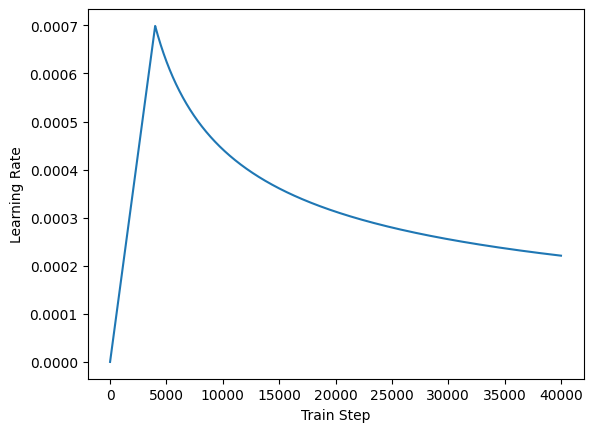

In [49]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')